In [1]:
from diffusers import StableDiffusionImageVariationPipeline
from PIL import Image
import torch
import matplotlib.pyplot as plt

sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained(
  "lambdalabs/sd-image-variations-diffusers",
  revision="v2.0",
)
sd_pipe.to(torch.device('cuda:0'))

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

StableDiffusionImageVariationPipeline {
  "_class_name": "StableDiffusionImageVariationPipeline",
  "_diffusers_version": "0.11.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
# This is same as the images in val tarfile
images = torch.load('val_images.pth', map_location=torch.device('cpu'))
# This is the val voxels encoded by brainnet
emb0 = torch.load('voxel_to_clip.pth', map_location=torch.device('cpu'))

In [28]:
import torchvision
mean=np.array([0.48145466, 0.4578275, 0.40821073])
std=np.array([0.26862954, 0.26130258, 0.27577711])
denorm = torchvision.transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

(-0.5, 223.5, 223.5, -0.5)

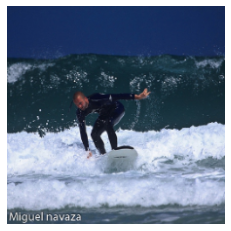

In [29]:
plt.imshow(denorm(images[0]).permute(1,2,0))
plt.axis('off')

In [3]:
image0 = images[0].unsqueeze(0)

In [4]:
gen = sd_pipe(image0, num_images_per_prompt=5)

  0%|          | 0/50 [00:00<?, ?it/s]

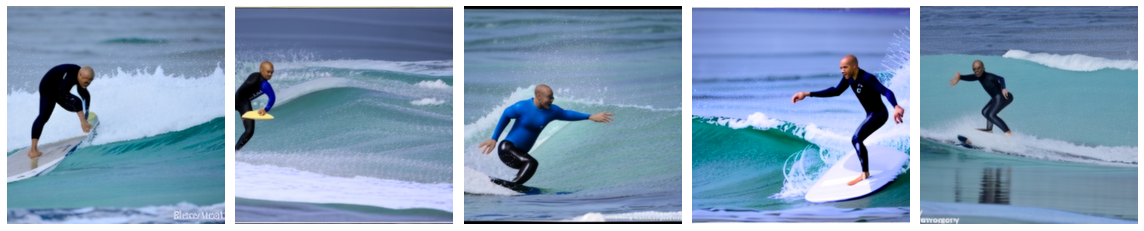

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,5,figsize=(16, 10))
for i in range(5):
    ax[i].imshow(gen.images[i])
    ax[i].axis('off')
fig.tight_layout()

In [18]:
@torch.no_grad()
# simnplified version of __call__ method in https://github.com/huggingface/diffusers/blob/9be94d9c6659f7a0a804874f445291e3a84d61d4/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_image_variation.py#L289
def brain_forward(
        brain_emb,
        sd_pipe,
        num_per_sample=5,
        num_inference_steps = 50,
        device=torch.device('cuda:0'),
    ):
        height = sd_pipe.unet.config.sample_size * sd_pipe.vae_scale_factor
        width = sd_pipe.unet.config.sample_size * sd_pipe.vae_scale_factor
        guidance_scale = 7.5
        do_classifier_free_guidance = True
        
        image_embeddings = brain_emb.repeat(num_per_sample, 1).unsqueeze(1)
        image_embeddings = torch.cat([torch.zeros_like(image_embeddings), image_embeddings], dim=0)

        # 4. Prepare timesteps
        sd_pipe.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = sd_pipe.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = sd_pipe.unet.in_channels
        latents = sd_pipe.prepare_latents(
            num_per_sample,
            num_channels_latents,
            height,
            width,
            image_embeddings.dtype,
            device,
            None,
            None,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = sd_pipe.prepare_extra_step_kwargs(None, 0.0)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * sd_pipe.scheduler.order
        with sd_pipe.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2)
                latent_model_input = sd_pipe.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = sd_pipe.unet(latent_model_input, t, encoder_hidden_states=image_embeddings).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = sd_pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % sd_pipe.scheduler.order == 0):
                    progress_bar.update()

        # 8. Post-processing
        image = sd_pipe.decode_latents(latents)

        # 9. Run safety checker
        image, has_nsfw_concept = sd_pipe.run_safety_checker(image, device, image_embeddings.dtype)
        return image

In [30]:
g1 = brain_forward(emb0[0][None].cuda() * 18.0576/emb0[0].norm(), sd_pipe)

  0%|          | 0/50 [00:00<?, ?it/s]

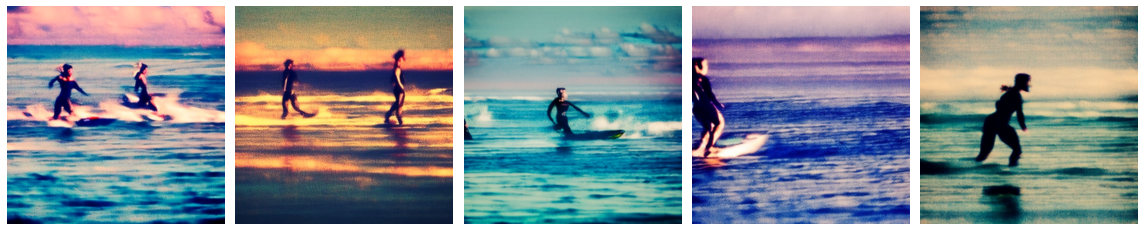

In [31]:
fig,ax = plt.subplots(1,5,figsize=(16, 10))
for i in range(5):
    ax[i].imshow(g1[i])
    ax[i].axis('off')
fig.tight_layout()

## Scratch

In [16]:
image0_emb = sd_pipe._encode_image(image0, torch.device('cuda:0'), 1, False)

In [51]:
# 5 samples per image, and do_guidance_free True
sd_pipe._encode_image(image0, torch.device('cuda:0'), 5, True).shape

torch.Size([10, 1, 768])

In [17]:
# Very different scales for brain_net and clip-L/14
emb0[0].norm(), image0_emb.norm()

(tensor(0.7129), tensor(18.0576, device='cuda:0', grad_fn=<CopyBackwards>))

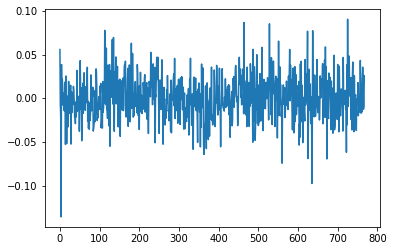

In [18]:
# brain net
plt.plot(emb0[0].cpu())

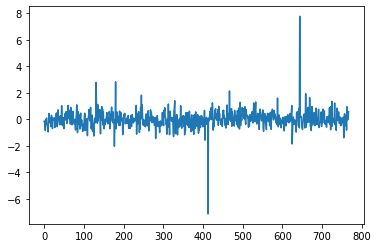

In [21]:
# clip embs have some "spikes" brain net does not capture these because we clamp at (-1.5, 1.5)
plt.plot(image0_emb[0,0].cpu().detach())

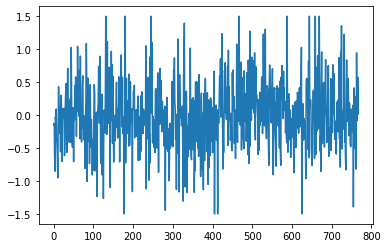

In [22]:
plt.plot(image0_emb[0,0].cpu().detach().clamp(-1.5, 1.5))

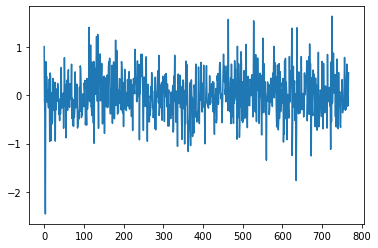

In [23]:
# some similarities visible between clip emb and brain emb in the middle and right part
plt.plot(emb0[0].cpu() * 18.0576)

In [32]:
# no rescaling
g1 = brain_forward(emb0[0][None].cuda(), sd_pipe)

  0%|          | 0/50 [00:00<?, ?it/s]

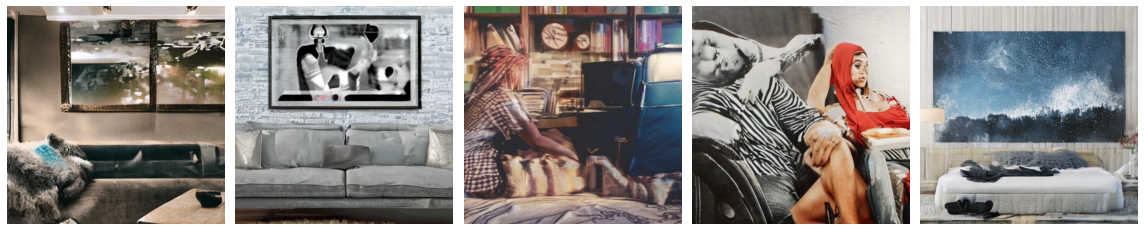

In [33]:
fig,ax = plt.subplots(1,5,figsize=(16, 10))
for i in range(5):
    ax[i].imshow(g1[i])
    ax[i].axis('off')
fig.tight_layout()

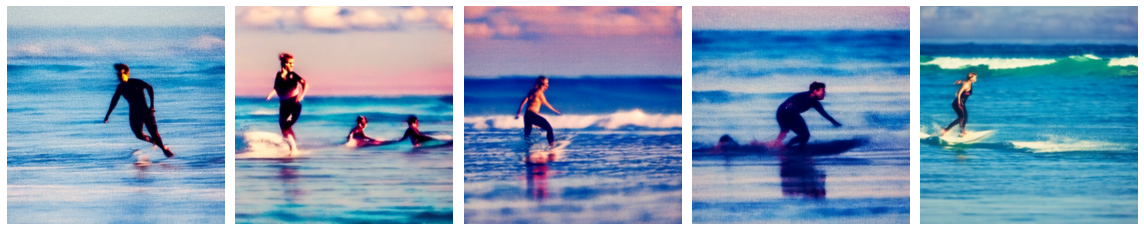

In [20]:
fig,ax = plt.subplots(1,5,figsize=(16, 10))
for i in range(5):
    ax[i].imshow(g1[i])
    ax[i].axis('off')
fig.tight_layout()

In [14]:
import numpy as np
brain_im = np.load('brain_image.pkl.npy')

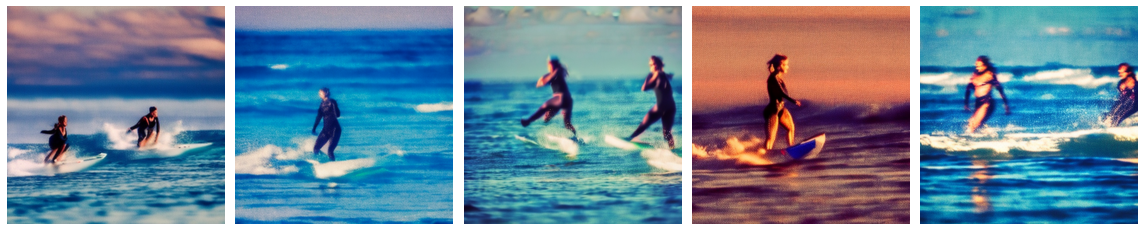

In [17]:
fig,ax = plt.subplots(1,5,figsize=(16, 10))
for i in range(5):
    ax[i].imshow(brain_im[i])
    ax[i].axis('off')
fig.tight_layout()

In [2]:
sd_pipe.image_encoder

CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096,